**Necessary Libraries Import**

In [1]:
!pip install scikeras

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.subplots import make_subplots
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, cross_val_score,train_test_split, RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')
from keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.constraints import MaxNorm
from scikeras.wrappers import KerasRegressor
from numpy import set_printoptions
from sklearn.feature_selection import SelectKBest,chi2
from sklearn.feature_selection import mutual_info_regression

## Data Import

In [3]:
gas_tur = pd.read_csv("gas_turbines.csv")
gas_tur.head(3)

,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX
0,6.8594,1007.9,96.799,3.5000,19.663,1059.2,550.00,114.70,10.605,3.1547,82.722
1,6.7850,1008.4,97.118,3.4998,19.728,1059.3,550.00,114.72,10.598,3.2363,82.776
2,6.8977,1008.8,95.939,3.4824,19.779,1059.4,549.87,114.71,10.601,3.2012,82.468


In [4]:
gas_tur.columns

Index(['AT', 'AP', 'AH', 'AFDP', 'GTEP', 'TIT', 'TAT', 'TEY', 'CDP', 'CO',
       'NOX'],
      dtype='object')

In [5]:
gas_tur.shape

(15039, 11)

## Data Exploration

+ Overall Description of Data

In [6]:
gas_tur.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15039 entries, 0 to 15038
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AT      15039 non-null  float64
 1   AP      15039 non-null  float64
 2   AH      15039 non-null  float64
 3   AFDP    15039 non-null  float64
 4   GTEP    15039 non-null  float64
 5   TIT     15039 non-null  float64
 6   TAT     15039 non-null  float64
 7   TEY     15039 non-null  float64
 8   CDP     15039 non-null  float64
 9   CO      15039 non-null  float64
 10  NOX     15039 non-null  float64
dtypes: float64(11)
memory usage: 1.3 MB


+ Missing Data

In [7]:
gas_tur.isnull().sum()

AT      0
AP      0
AH      0
AFDP    0
GTEP    0
TIT     0
TAT     0
TEY     0
CDP     0
CO      0
NOX     0
dtype: int64

+ Duplicate Data

In [8]:
gas_tur[gas_tur.duplicated()]

,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX


### From the Data exploration it can be concluded that
+ There is no missing value in the Data set
+ There are no duplicated values in the Data set

## Data Visualization

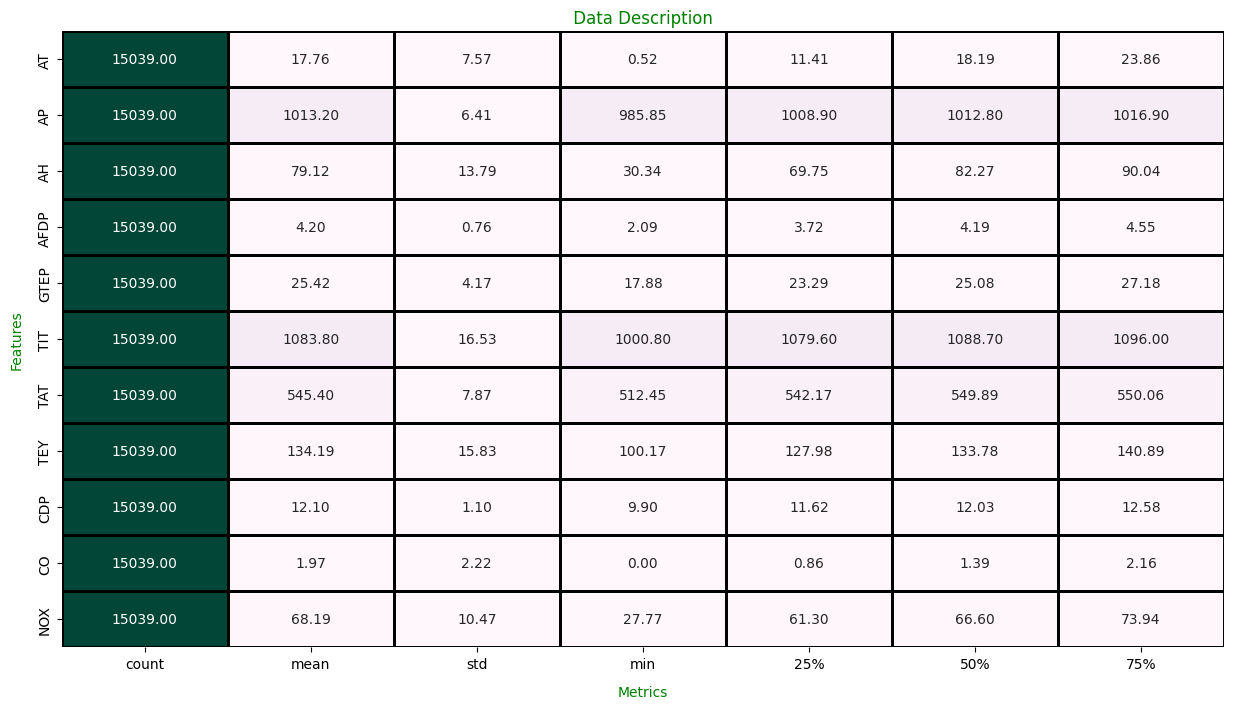

In [9]:
report = gas_tur.describe().T
df_report = pd.DataFrame(report).transpose()

plt.figure(figsize=(15, 8))
sns.heatmap(df_report.iloc[:-1, :].T, annot=True, cmap="PuBuGn", fmt=".2f", linewidths=1, linecolor="black",cbar=False)
plt.title(' Data Description ', color='Green')
plt.xlabel('Metrics',labelpad=10,color='Green')
plt.ylabel('Features',labelpad=10, color='Green')
plt.show()

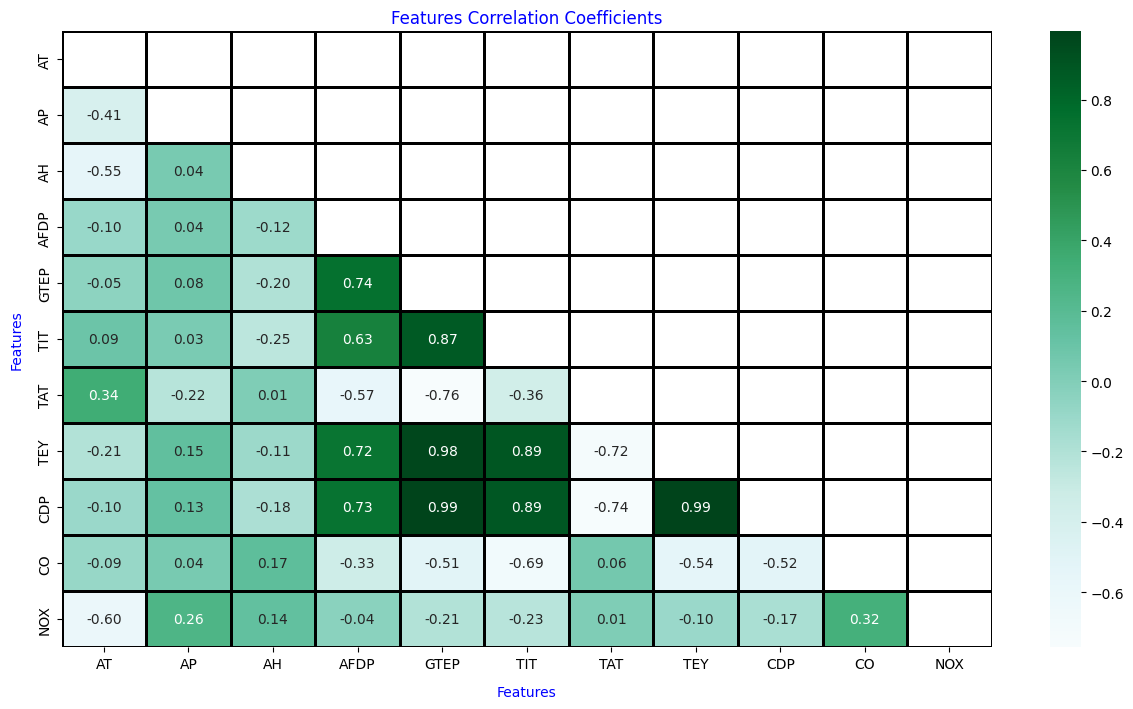

In [11]:
report = gas_tur.corr().T
mask = np.triu(np.ones_like(report, dtype=bool)) # Shows only the Upper Traiangle

plt.figure(figsize=(15, 8))
sns.heatmap(report, mask=mask, annot=True, cmap="BuGn", fmt=".2f", linewidths=1, linecolor="black", cbar=True)
plt.title('Features Correlation Coefficients', color='Blue')
plt.xlabel('Features', labelpad=10, color='Blue')
plt.ylabel('Features', labelpad=10, color='Blue')
plt.show()

## Univariate Analysis for all the variables (Numeric)

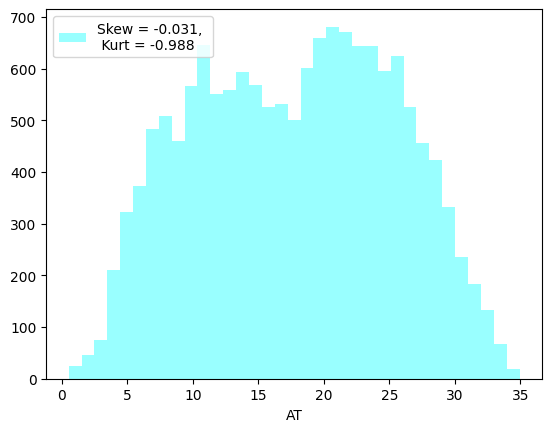

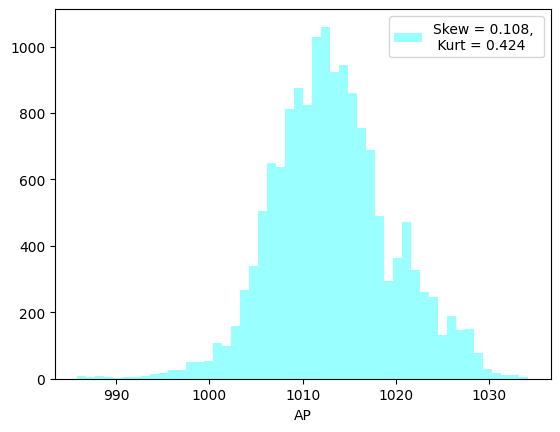

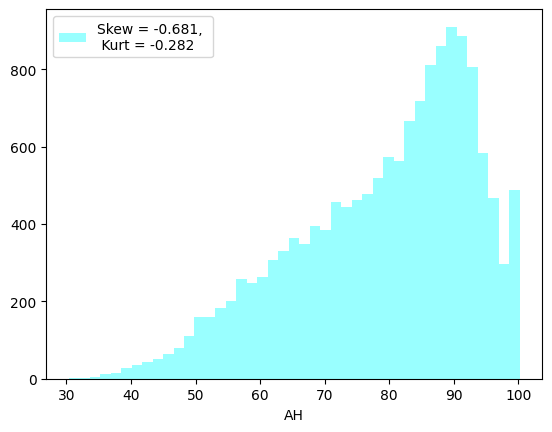

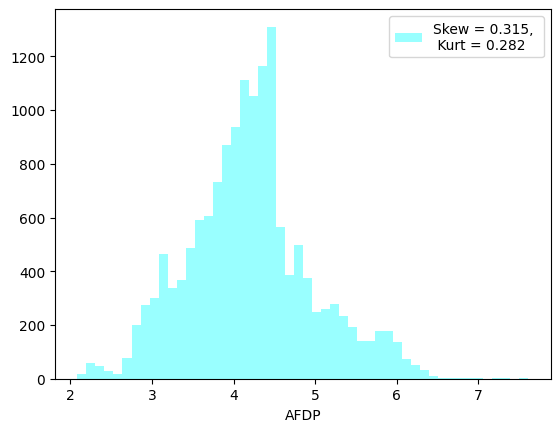

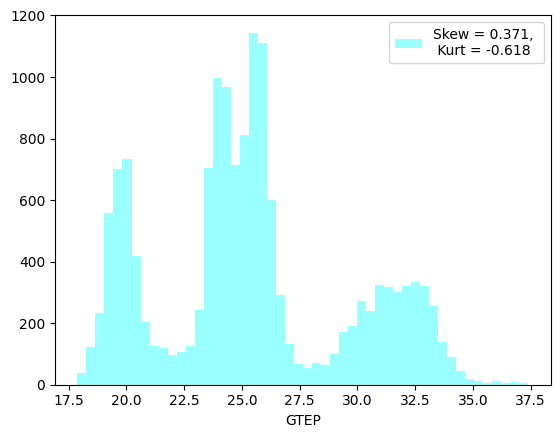

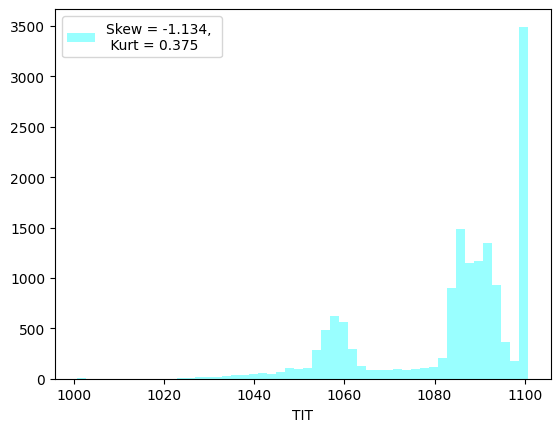

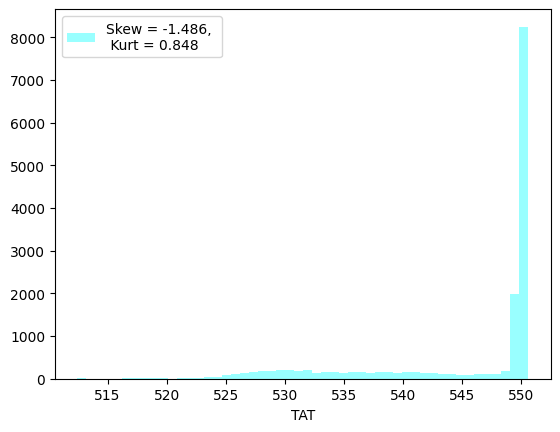

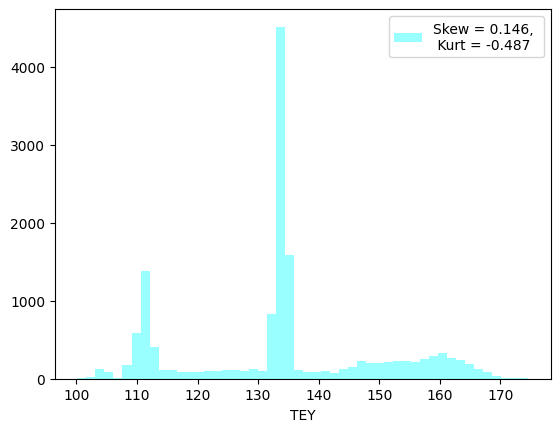

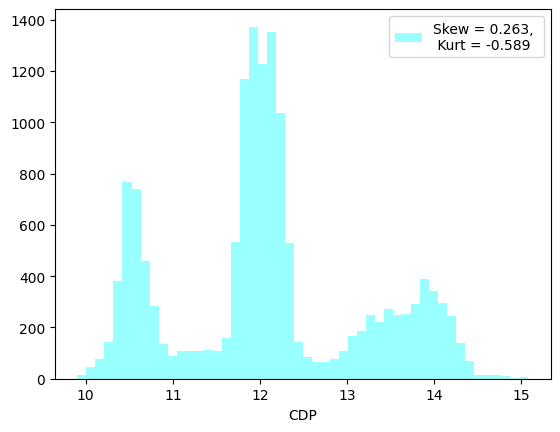

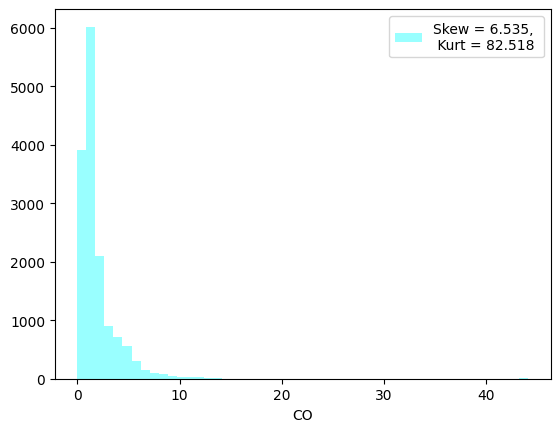

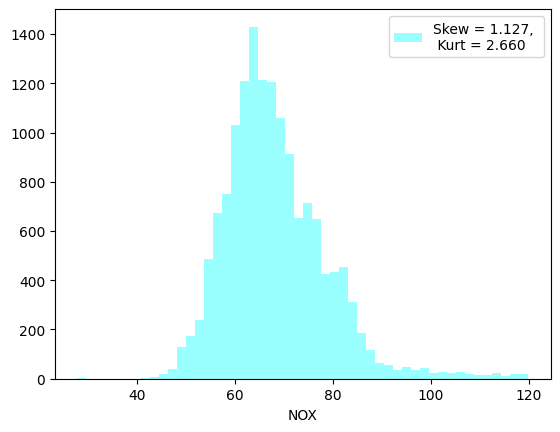

In [ ]:
for feature in gas_tur.columns:
  skewness = gas_tur[feature].skew()
  kurtosis = gas_tur[feature].kurt()
  sns.distplot(gas_tur[feature],kde=False, color='cyan',label="Skew = %.3f, \n Kurt = %.3f"%(skewness,kurtosis))
  plt.legend(loc='best')
  plt.show()

## As we can see that Some of the Features are normally Distributed. However, Features like :-
+ TIT
+ TAT
+ NOx

are skewed hower the feature
+ CO

is skewed as well has very high value of kurtosis

## Now let's check the presence of outliers - using Turkey's Method

In [ ]:
from collections import Counter

In [ ]:
def detect_outliers(df):
  "This function is expected to take a dataframe as input and return a lis of indices of the observations which contain more than 2 outliers"
  out_ind = []

  for col in df.columns.tolist():

    # First Quartile (25%)
    Q1 = np.percentile(df[col],25)

    # Third Quartile (75%)
    Q3 = np.percentile(df[col],75)

    # Interquatile Range (IQR)
    IQR = Q1-Q3

    # IQR Multiplier
    Multiplier = 1.5*IQR

    # List of indices for the outliers
    outlier_lndex_list = df[(df[col] < Q1-Multiplier) | (df[col] > Q3 + Multiplier)].index

    # Extend the outlier index list
    out_ind.extend(outlier_lndex_list)
  # select observations containing more than 2 outliers
  out_ind = Counter(out_ind)
  multiple_outliers = list( k for k, v in out_ind.items() if v > 2 )
  return multiple_outliers

print('The dataset contains %d observations with more than 2 outliers' %(len(detect_outliers(gas_tur))))

The dataset contains 15039 observations with more than 2 outliers


## We can see that ther are many outliers in the Data let's Draw the box plot in order to visualize it

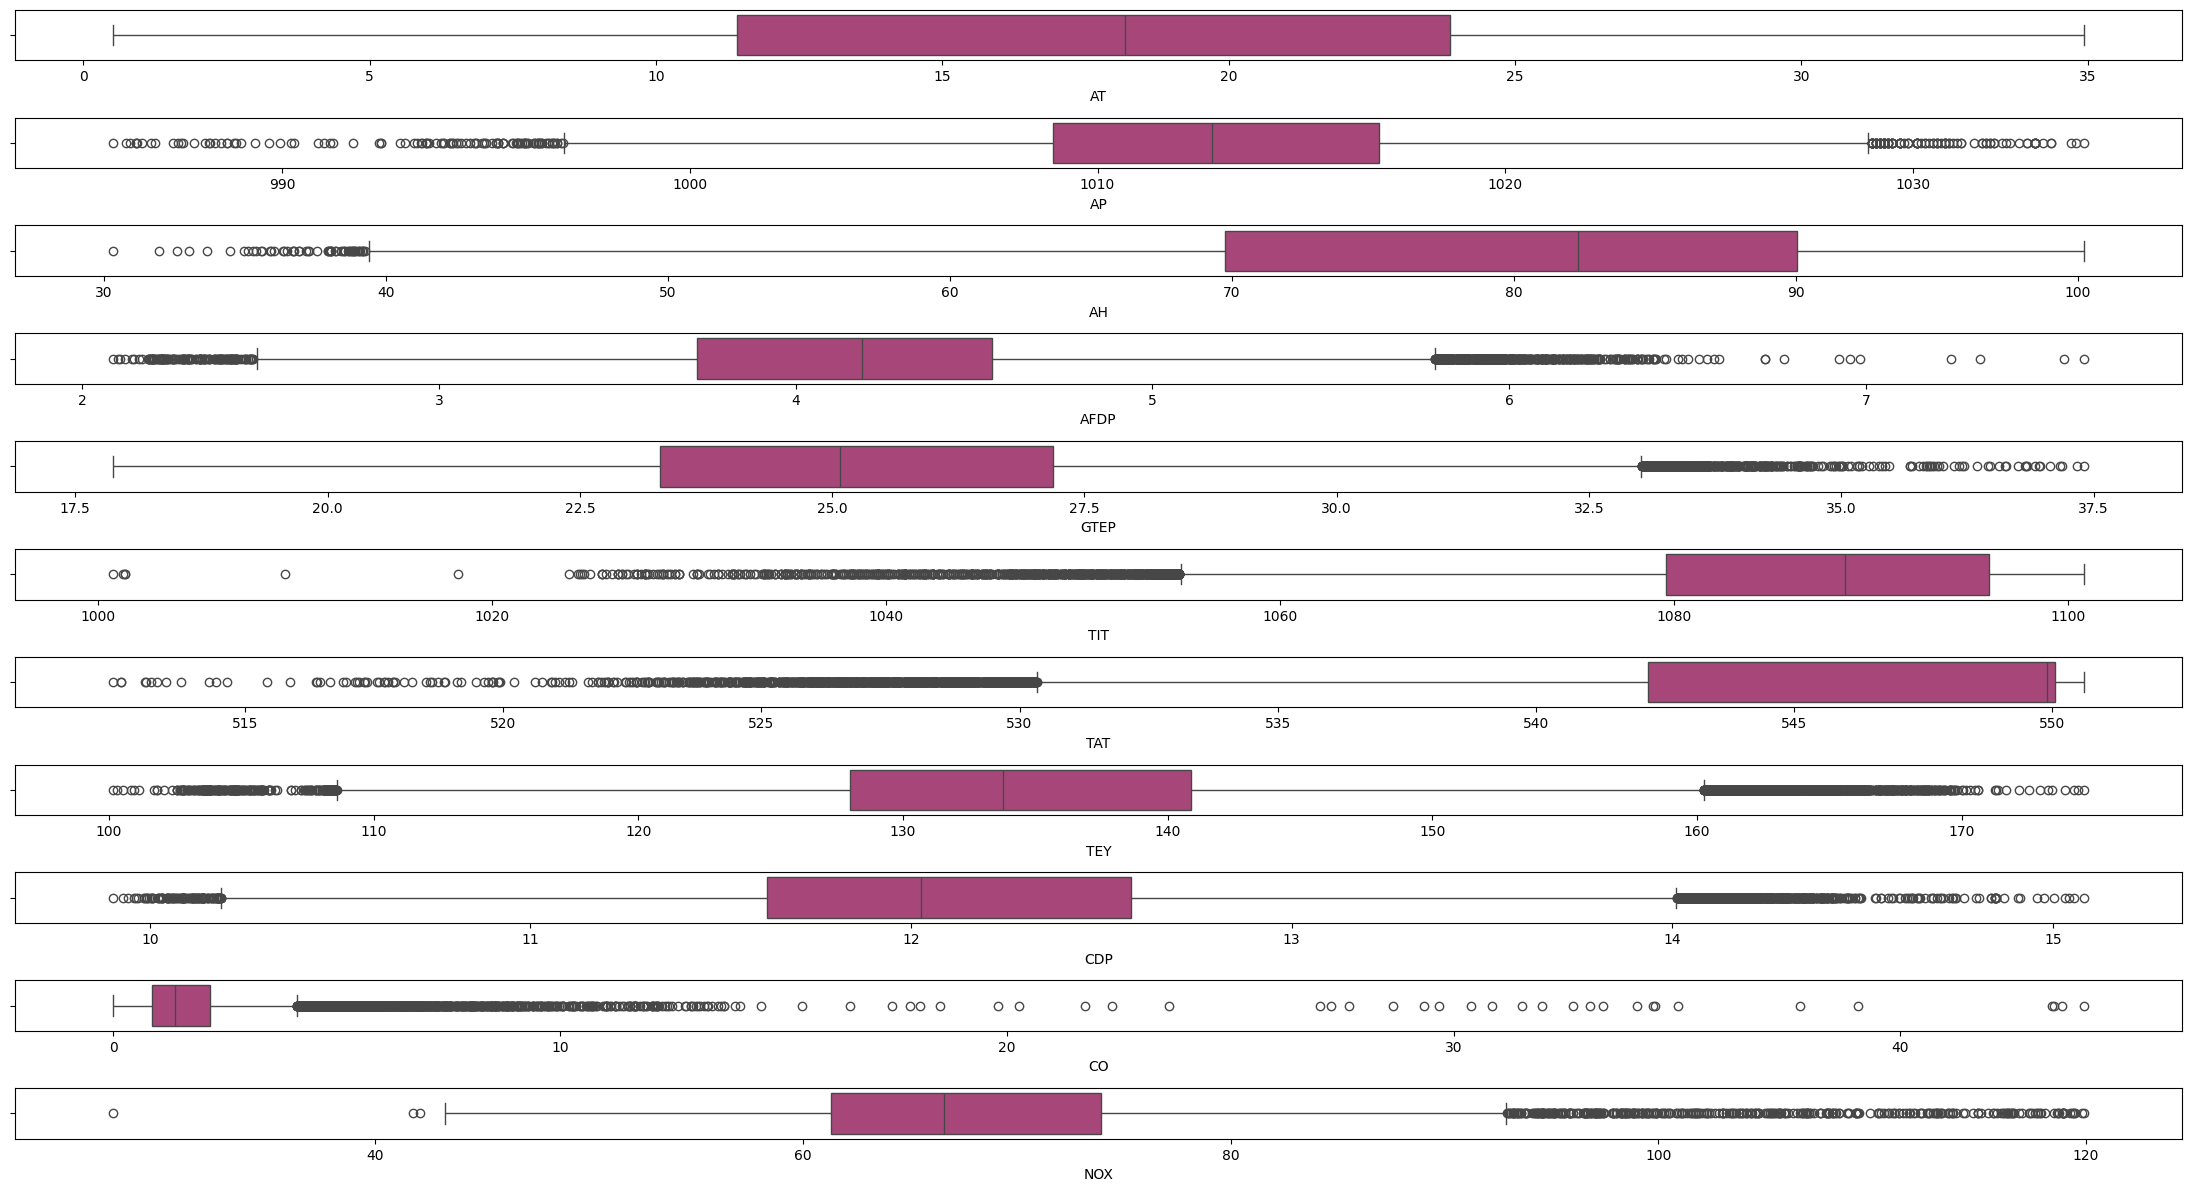

In [ ]:
outlier_data = gas_tur.copy()
fig, axes=plt.subplots(len(outlier_data.columns.to_list()),1,figsize=(22,12),sharex=False,sharey=False)
for i in range(len(outlier_data.columns.to_list())):
  sns.boxplot(x=outlier_data.iloc[:,i],palette='magma',data=outlier_data,ax=axes[i])
plt.tight_layout(pad=1.0)

<Axes: >

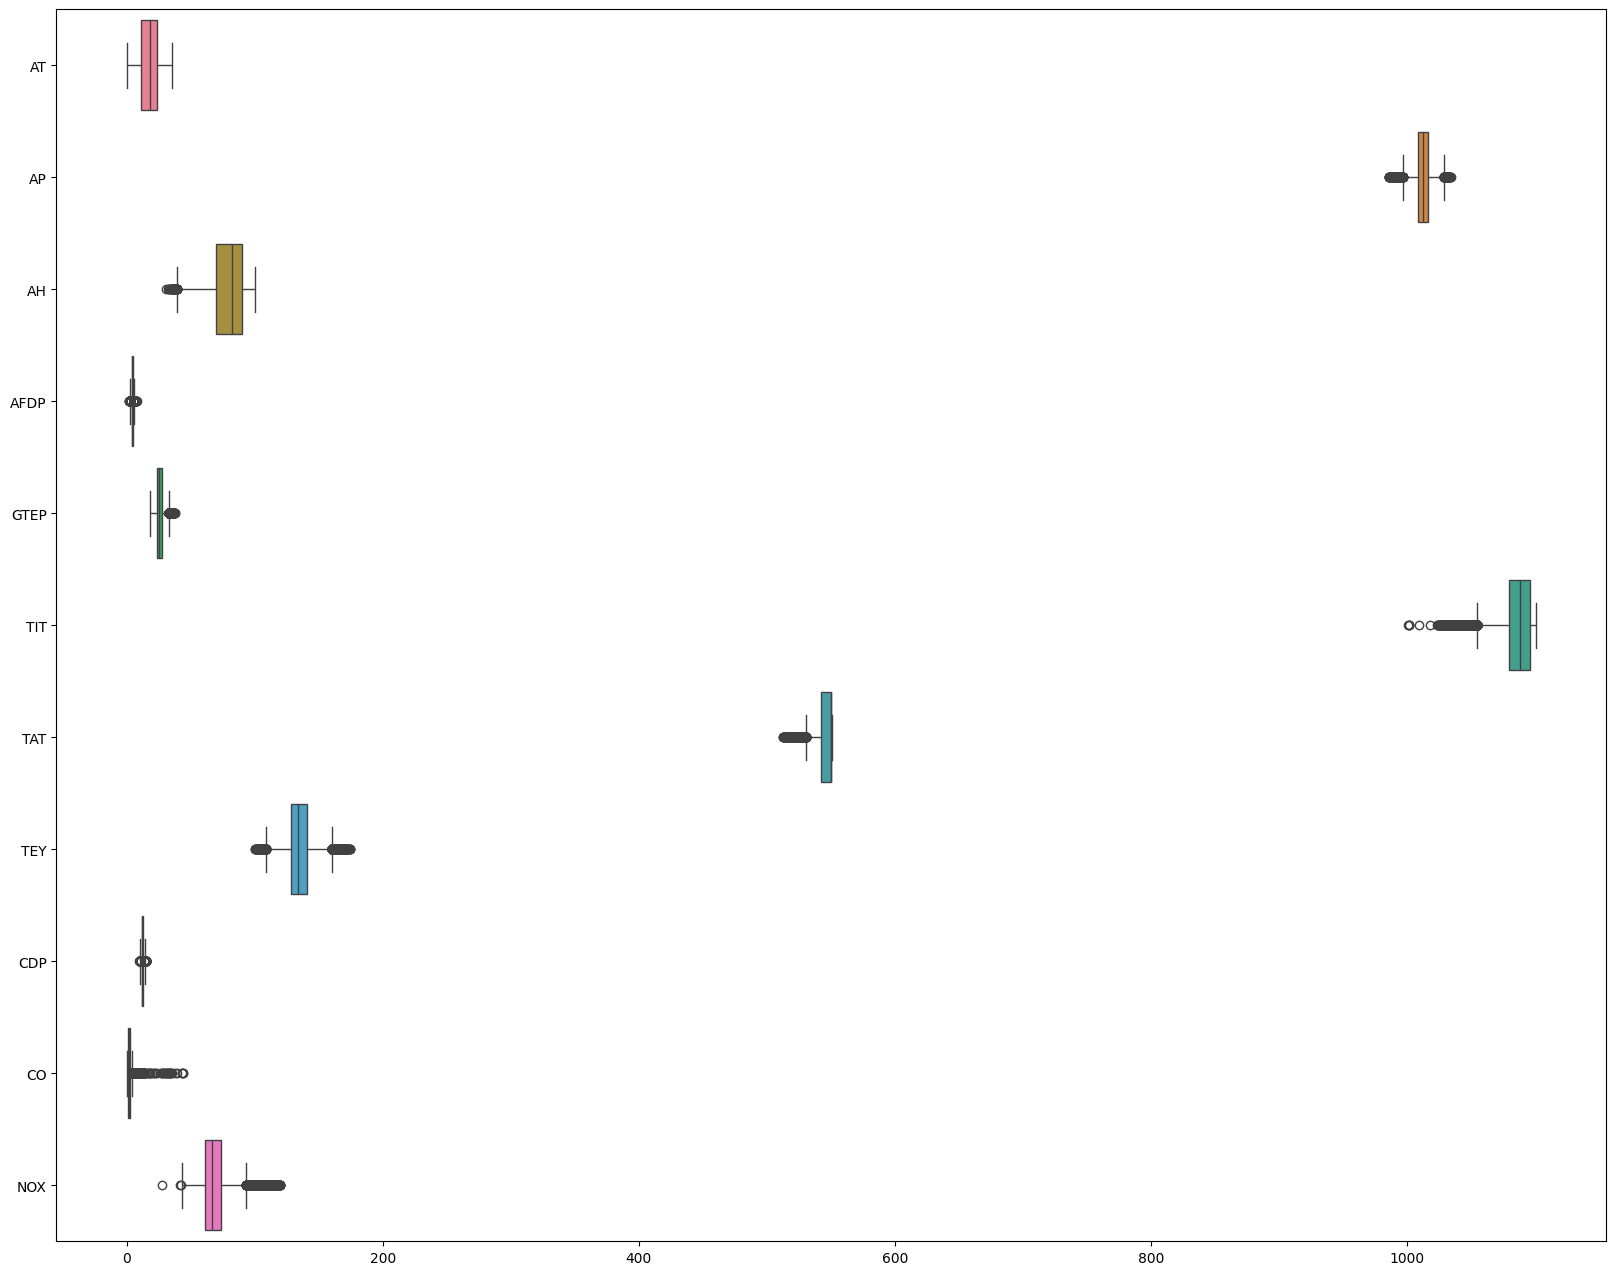

In [ ]:
#outlier
plt.figure(figsize=(20,16))
sns.boxplot(data=outlier_data, orient="h")

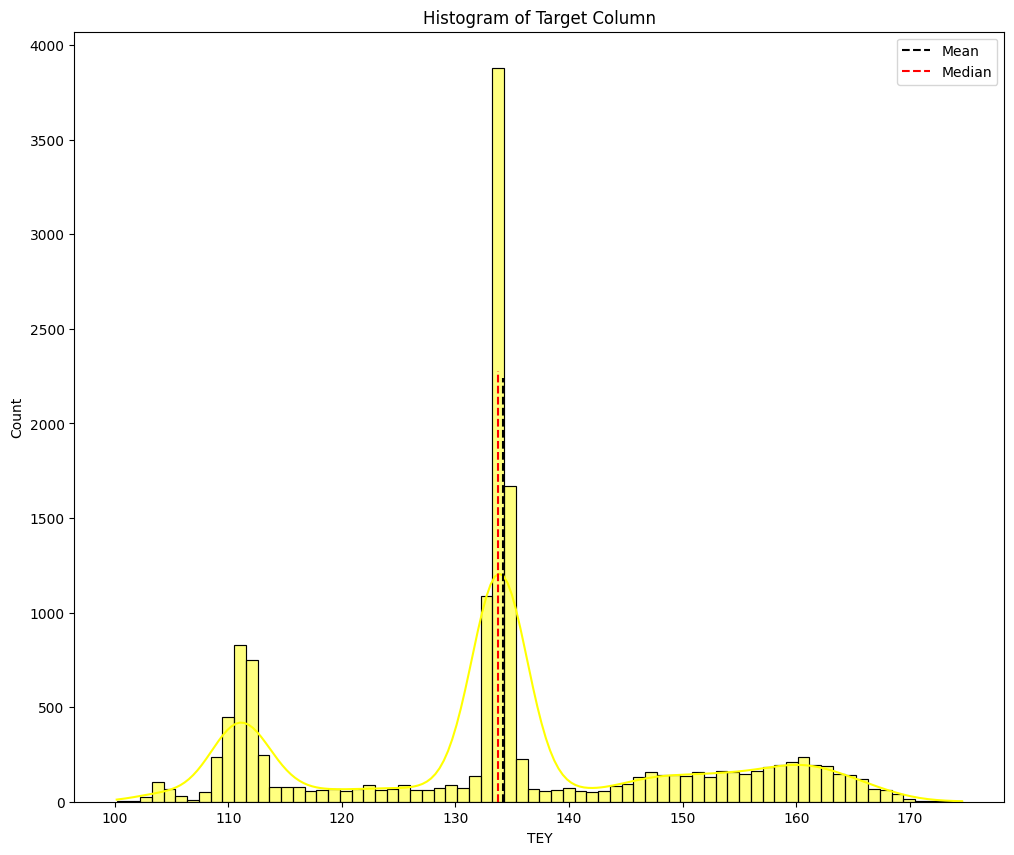

In [ ]:
plt.figure(figsize=(12,10))
sns.histplot(data=gas_tur,x="TEY",color="yellow",kde=True)
plt.axvline(x=gas_tur["TEY"].mean(),ymax=0.55,color="black",linestyle='--',label="Mean")
plt.axvline(x=gas_tur["TEY"].median(),ymax=0.56,color="red",linestyle='--',label="Median")
plt.legend()
plt.title("Histogram of Target Column")
plt.show()

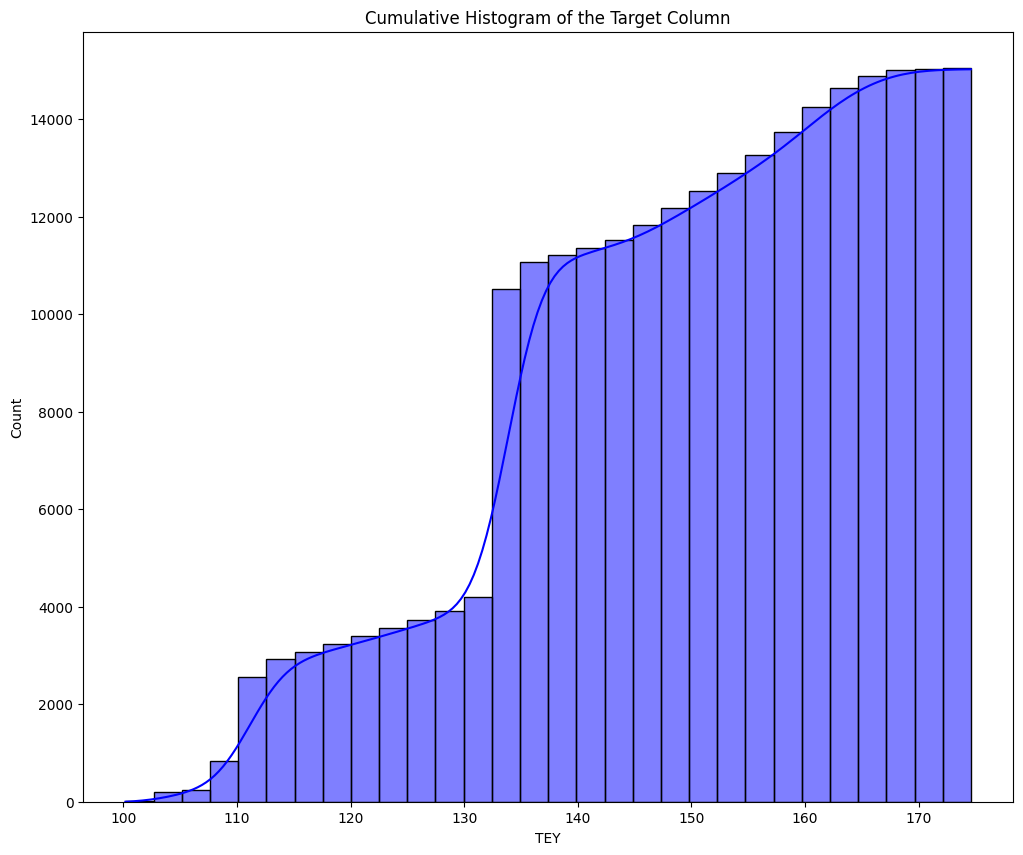

In [ ]:
plt.figure(figsize = (12,10))
sns.histplot(gas_tur["TEY"],kde=True,bins=30,color="blue",cumulative=True)
plt.title("Cumulative Histogram of the Target Column")
plt.show()

## As we have already seen non of the features are on the same scale

## Multivariate Analysis :- Now we visually the variation of Target Variable 'TEY' w.r.t all other variables

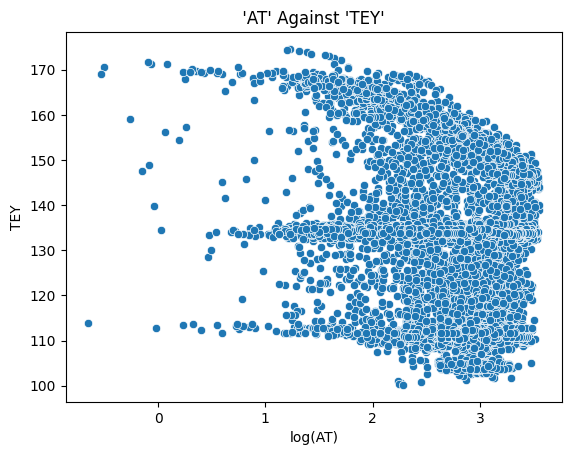

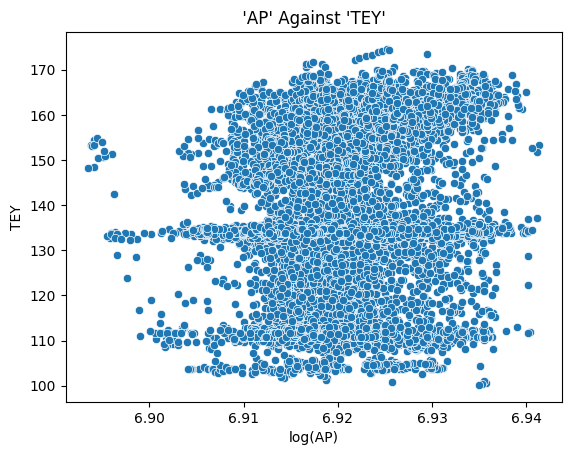

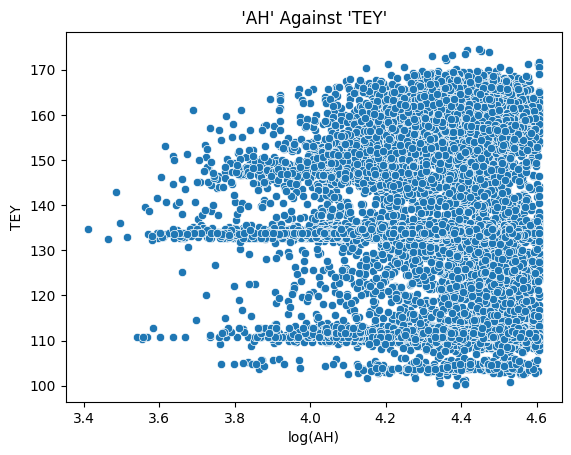

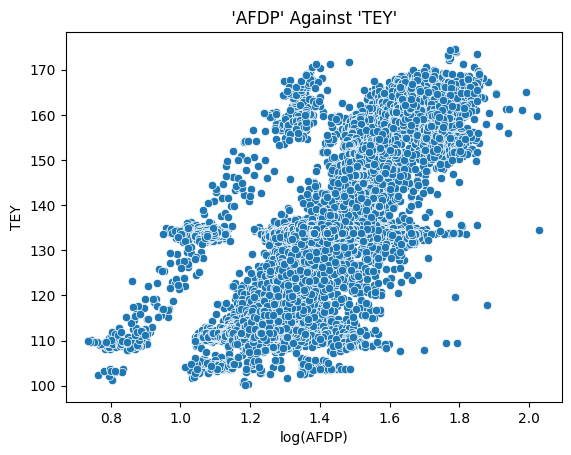

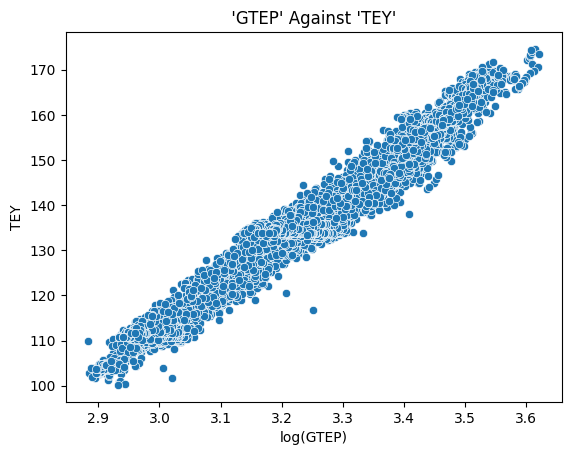

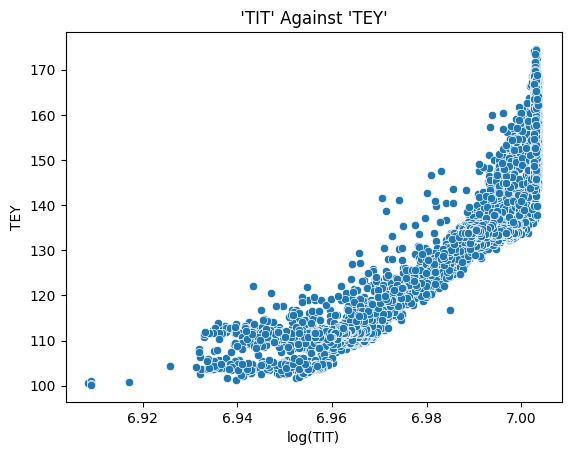

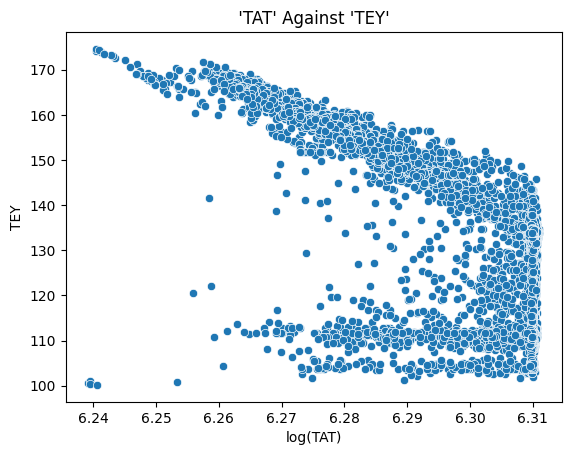

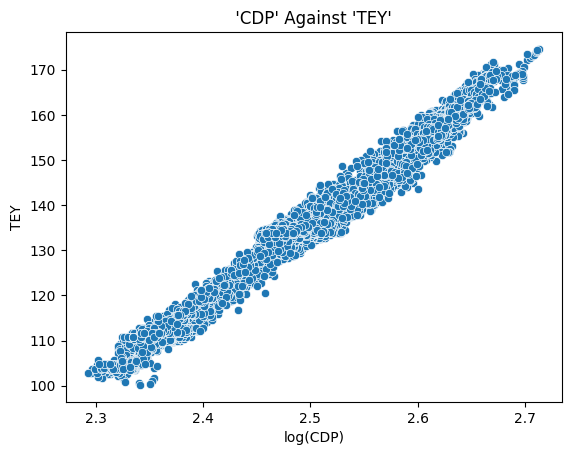

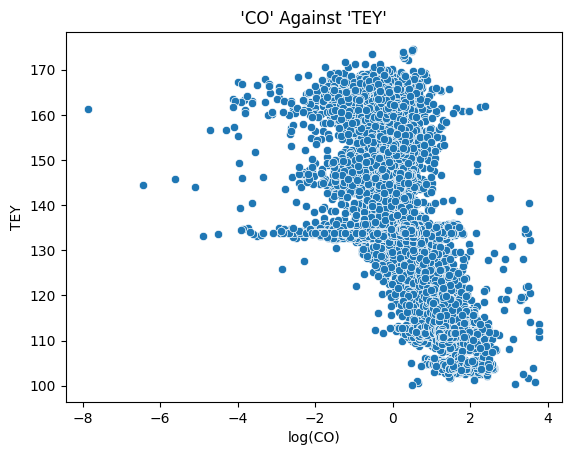

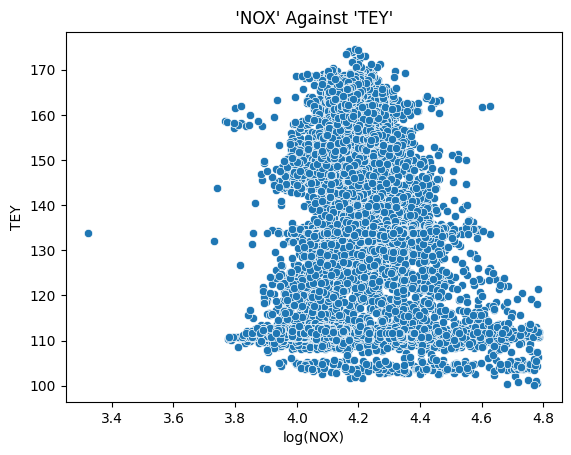

In [ ]:
for col in gas_tur.columns.to_list() :
  if col != 'TEY':
    sns.scatterplot(x = np.log(gas_tur[col]),y=gas_tur["TEY"],data=gas_tur)
    plt.title(f" '{col}' Against 'TEY' ")
    plt.xlabel(f"log({col})")
    plt.show()

Text(0.5, 1.0, 'Correlation with Turbine energy yield \n')

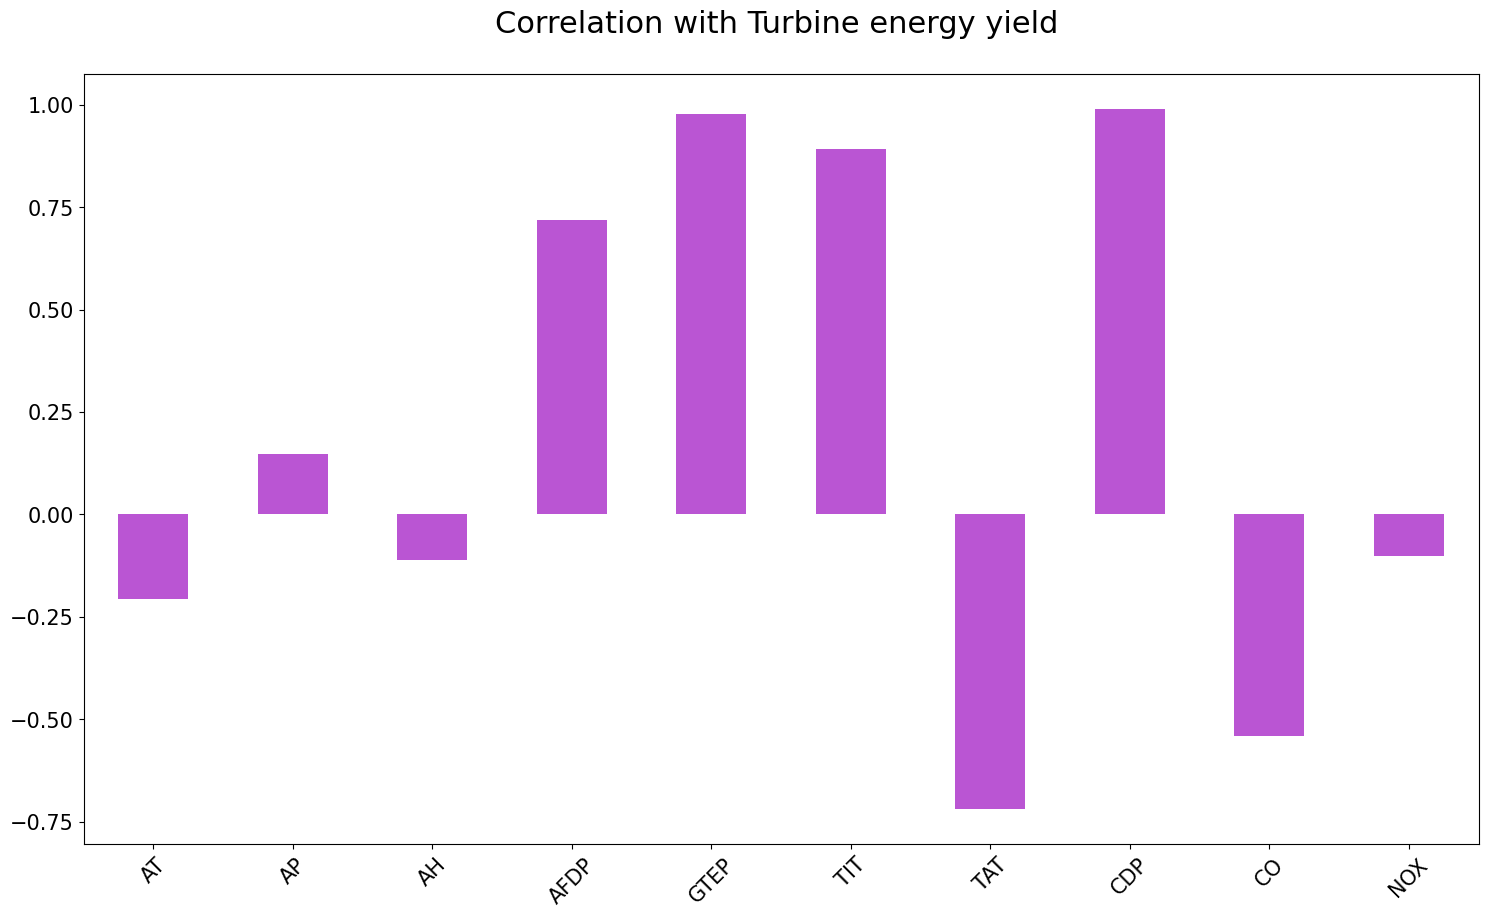

In [ ]:
data = gas_tur.copy()

correlations = data.corrwith(data.TEY)
correlations = correlations[correlations!=1]
positive_correlations = correlations[correlations >0].sort_values(ascending = False)
negative_correlations =correlations[correlations<0].sort_values(ascending = False)

correlations.plot.bar(
        figsize = (18, 10),
        fontsize = 15,
        color = '#ba55d3',
        rot = 45,
        grid = False)
plt.title('Correlation with Turbine energy yield \n',
horizontalalignment="center", fontstyle = "normal",
fontsize = "22")

<Figure size 2000x2000 with 0 Axes>

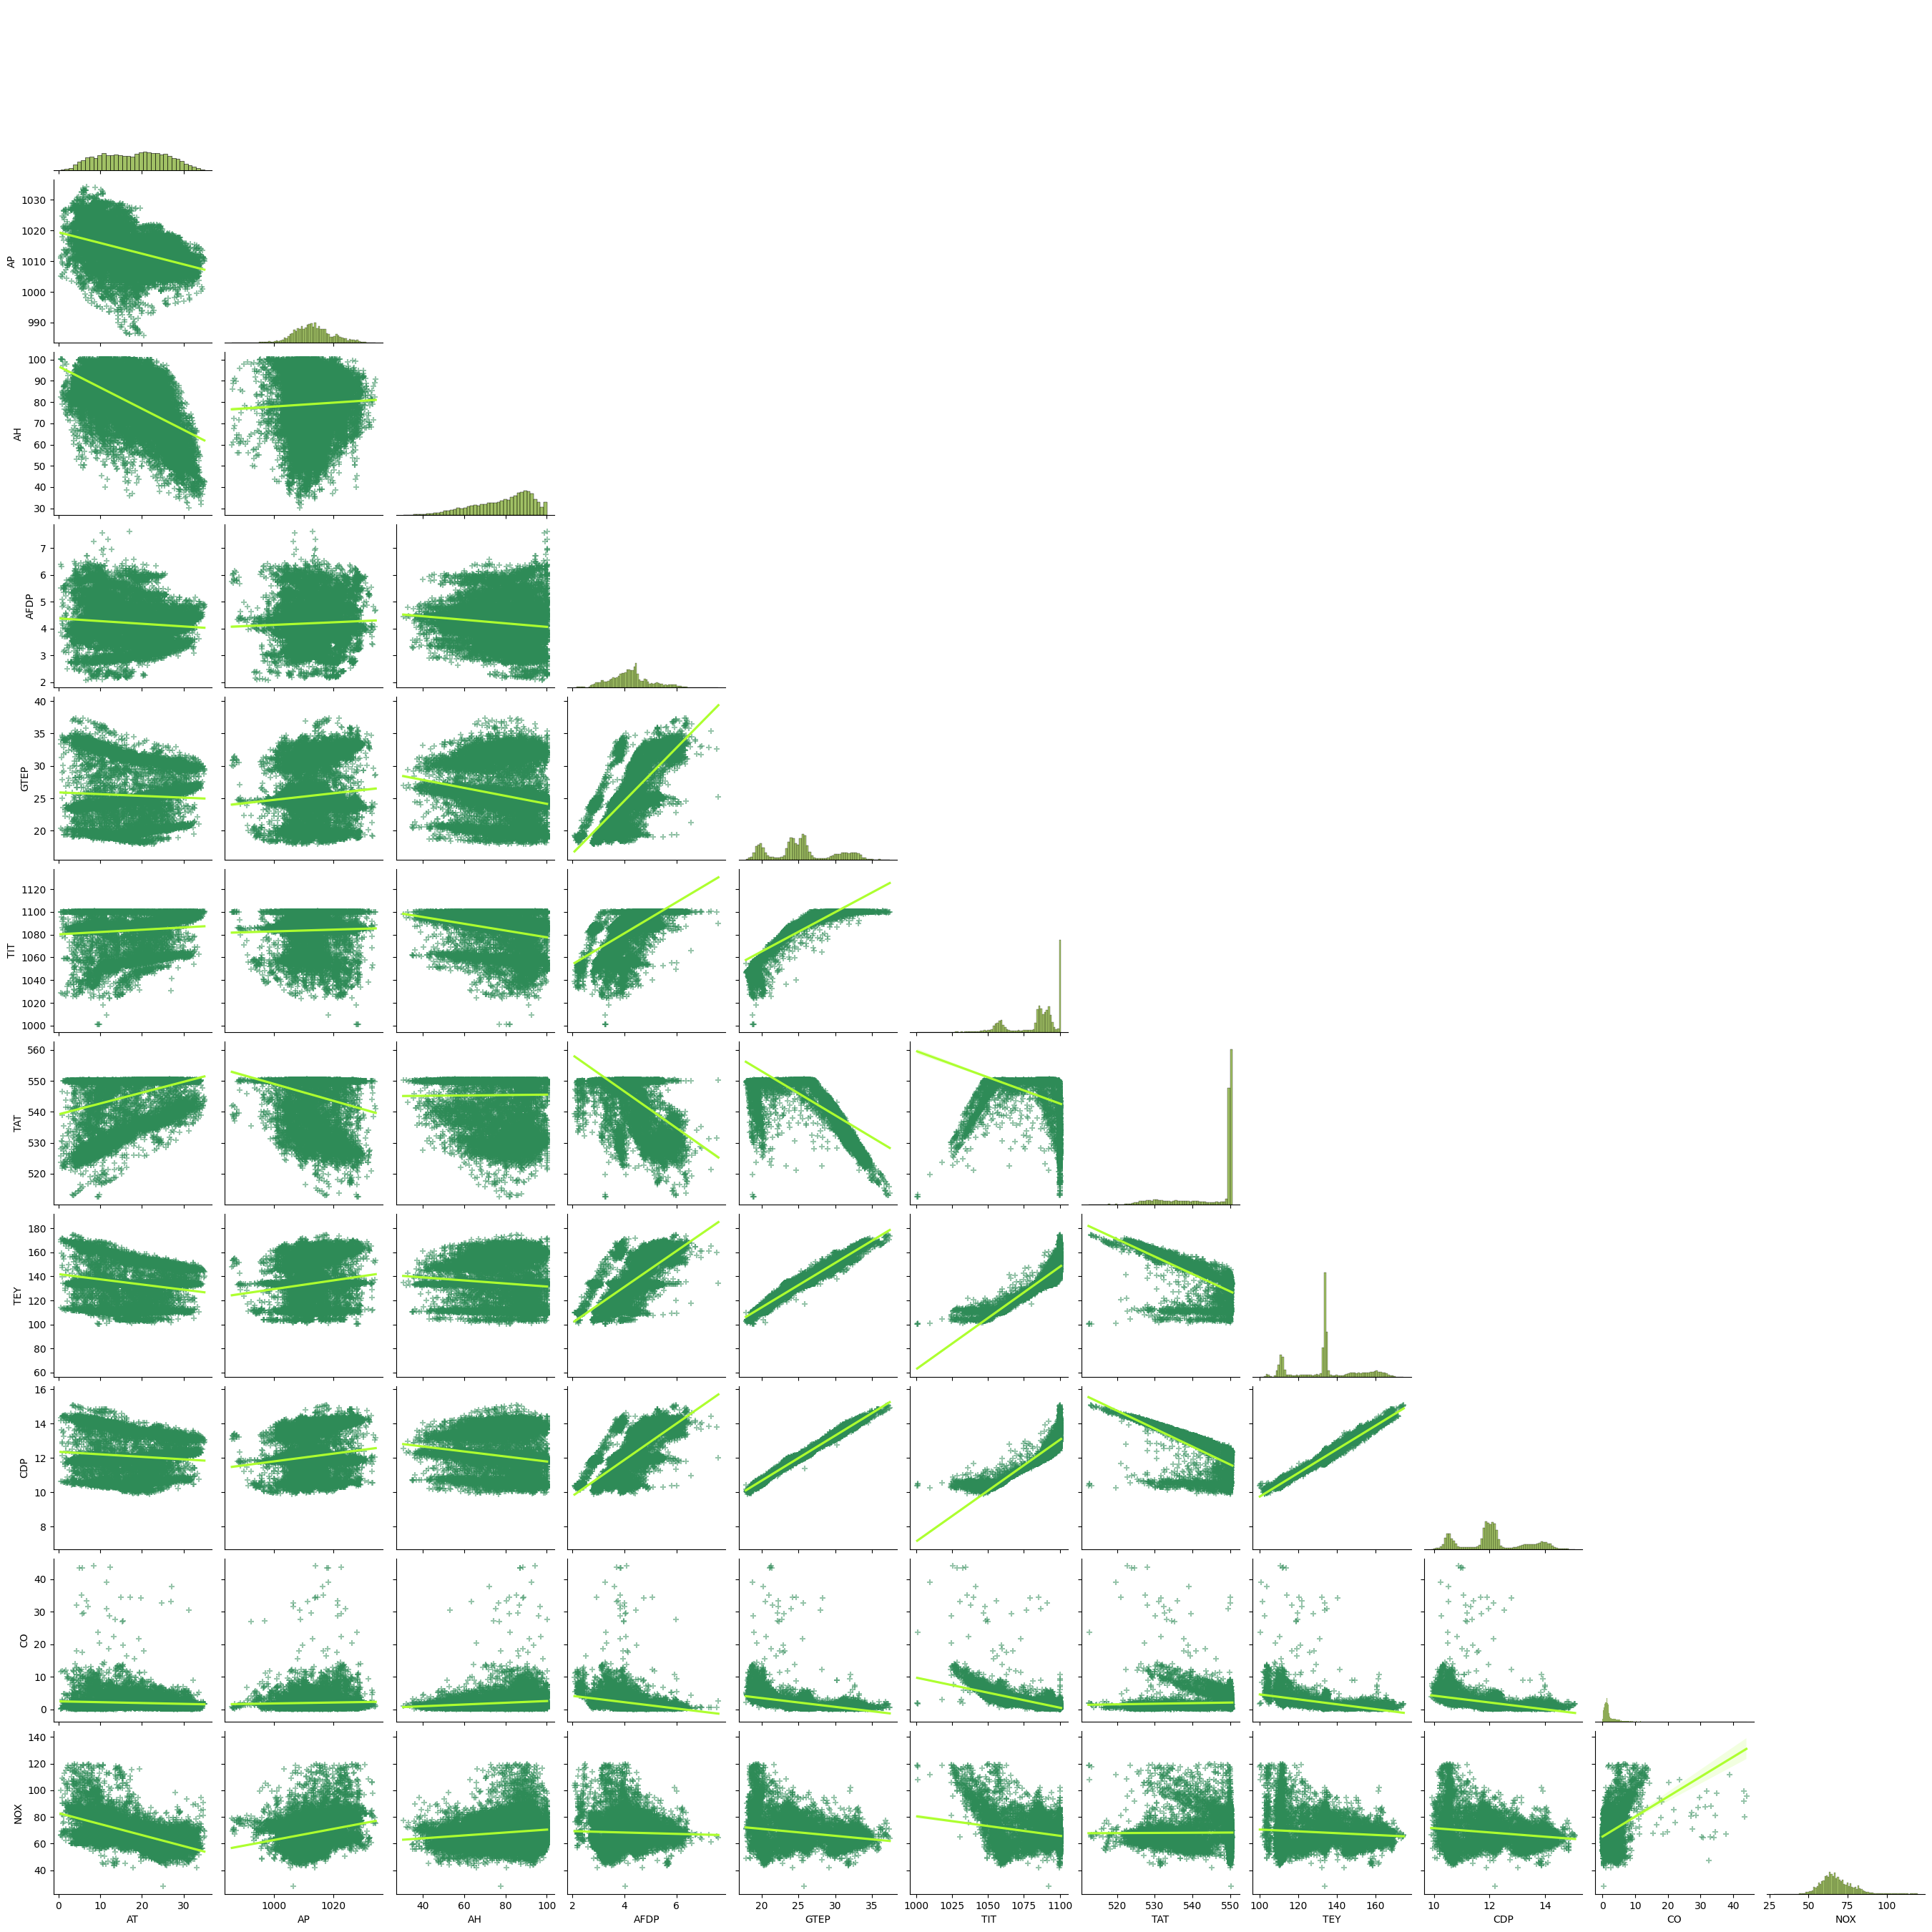

In [ ]:
plt.figure(figsize=(20,20))
sns.pairplot(gas_tur,
                 markers="+",
                 kind='reg',
                 diag_kind="hist",
                 plot_kws={'line_kws':{'color':'#adff2f'},
                           'scatter_kws': {'alpha': 0.5,
                                           'color': '#2e8b57'}},
               corner=True,
                 diag_kws= {'color': '#82ad32'})
plt.show()

In [ ]:
x = gas_tur.drop('TEY',axis=1)
y = gas_tur['TEY']

In [ ]:
print(x.head(3),'\n\n')
print(y.head(3))

       AT      AP      AH    AFDP    GTEP     TIT     TAT     CDP      CO  \
0  6.8594  1007.9  96.799  3.5000  19.663  1059.2  550.00  10.605  3.1547   
1  6.7850  1008.4  97.118  3.4998  19.728  1059.3  550.00  10.598  3.2363   
2  6.8977  1008.8  95.939  3.4824  19.779  1059.4  549.87  10.601  3.2012   

      NOX  
0  82.722  
1  82.776  
2  82.468   


0    114.70
1    114.72
2    114.71
Name: TEY, dtype: float64


# Feature Selection - using K-Best Features

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression

In [ ]:
test = SelectKBest(score_func =mutual_info_regression,k='all') # Final selection will be based on this value only
fit_func = test.fit(x,y)

In [ ]:
score = fit_func.scores_
feat_final = fit_func.transform(x)

In [ ]:
score_df = pd.DataFrame(list(zip(score,x.columns)),
                                   columns = ['Score','Feature'])
score_df.sort_values(by="Score", ascending=False,inplace=True)
score_df

,Score,Feature
7,1.713166,CDP
4,1.599805,GTEP
5,1.324529,TIT
6,0.895570,TAT
3,0.660652,AFDP
8,0.512651,CO
0,0.412341,AT
9,0.301047,NOX
1,0.136187,AP
2,0.097660,AH


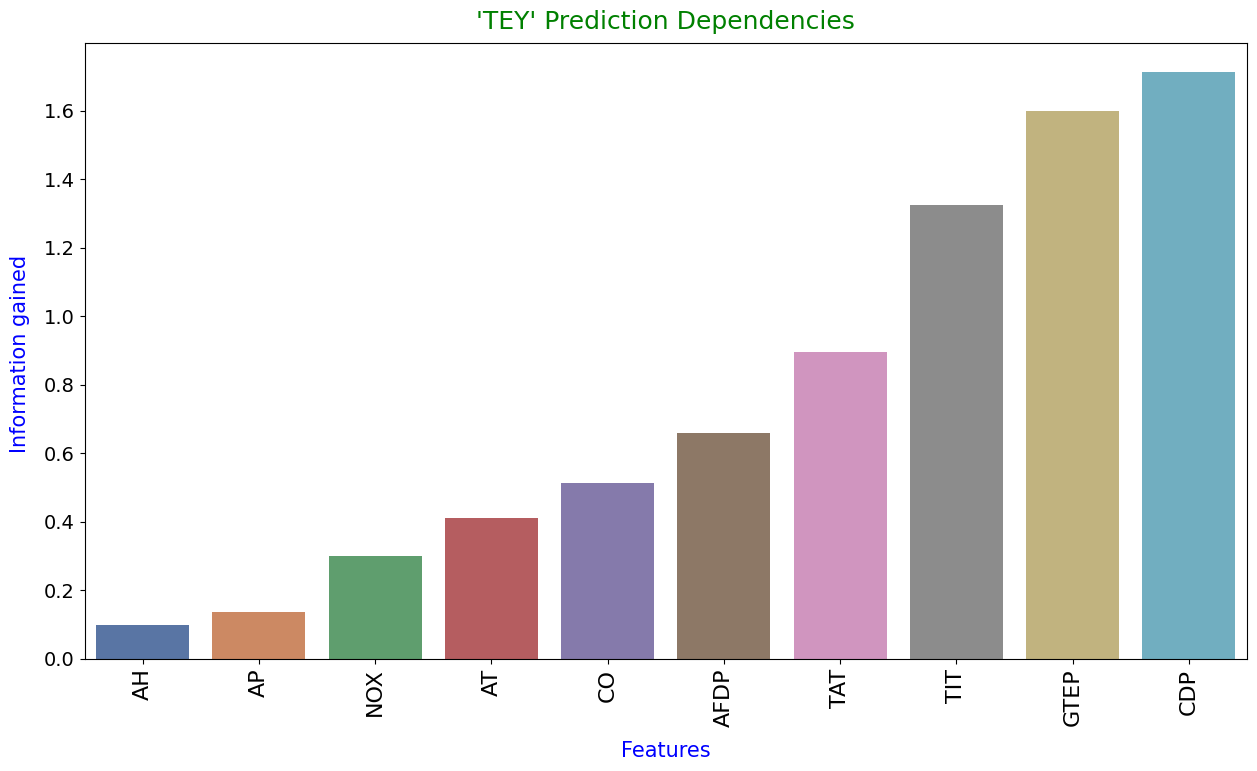

In [ ]:
plt.figure(figsize=(15,8))
sns.barplot(x='Feature', y = 'Score', data=score_df,
            order=score_df.sort_values('Score').Feature,
            palette='deep')
            #order=score_df.Score.sort_values())
plt.xlabel('Features',fontsize=15,labelpad=10,color='Blue')
plt.ylabel('Information gained ',fontsize=15,labelpad=10,color='Blue')
plt.yticks(rotation = 0, fontsize = 14)
plt.xticks(rotation = 90, fontsize = 16)
plt.title("'TEY' Prediction Dependencies",fontsize=18,pad=10,color='Green')
plt.show()

In [ ]:
nn_data = gas_tur[['CDP','GTEP','TIT','TAT','AFDP','CO','AT','TEY']]
nn_data.head()

,CDP,GTEP,TIT,TAT,AFDP,CO,AT,TEY
0,10.605,19.663,1059.2,550.00,3.5000,3.1547,6.8594,114.70
1,10.598,19.728,1059.3,550.00,3.4998,3.2363,6.7850,114.72
2,10.601,19.779,1059.4,549.87,3.4824,3.2012,6.8977,114.71
3,10.606,19.792,1059.6,549.99,3.4805,3.1923,7.0569,114.72
4,10.612,19.765,1059.7,549.98,3.4976,3.2484,7.3978,114.72


## Data Preprocessing